In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import allel

import  umap
import umap.plot

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

%matplotlib inline

## UMAP

In [2]:
chr7_females = allel.read_vcf('../steps/recode_vcf/chr7_females.recode.vcf')

In [3]:
chrX_females = allel.read_vcf('../steps/recode_vcf/chrX_females.recode.vcf')

In [4]:
meta_data_samples = pd.read_table("../data/metadata.txt", sep=" ")

In [5]:
meta_data_females = meta_data_samples[meta_data_samples['Sex'] == 'F']

In [6]:
def vcf2df(vcf):
    gt = allel.GenotypeArray(vcf['calldata/GT'])
    ac = gt.count_alleles()
    
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = gt.compress(flt, axis=0)

    gn = gf.to_n_alt()
    
    return gn

In [7]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [8]:
def perform_umap(df, vcf, pop):
    
    scaled_df = StandardScaler().fit_transform(df)
    
    reducer = umap.UMAP(random_state=23)
    
    embedding = reducer.fit_transform(scaled_df.T)
    
    umap_df = pd.DataFrame(data = embedding,
                           columns = ['1', '2'], 
                           index=vcf['samples'])
    
    pop = pop.set_index('PGDP_ID')
    
    final_df = pd.merge(umap_df, pop['C_origin'], left_index=True, right_index=True)
    
    return final_df

In [9]:
def plot_umap(df, chrom, pop):
    fig, ax = plt.subplots(figsize = (6,5))

    groups = df.groupby('C_origin')
    for name, group in groups:
        ax.scatter(group['1'], group['2'], 
                   label=name, s=12, 
                   cmap='Paired')
    
    ax.set_title('UMAP projection', fontsize = 15)
    ax.legend(bbox_to_anchor=(1.01, 0.75))
    
    plt.show()
    fig.savefig('../figures/umap{}_{}.pdf'.format(pop, chrom), bbox_inches='tight')

### UMAP Projections

#### Females chromosome 7

In [10]:
df = vcf2df(chr7_females)

In [11]:
pruned_df = ld_prune(df, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 333530 removing 2616101 variants


In [12]:
chr7_females_umap = perform_umap(pruned_df, chr7_females, meta_data_females)

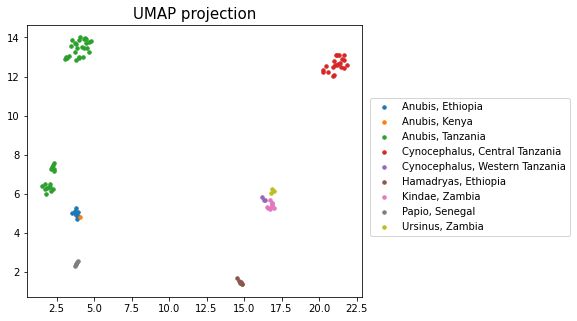

In [13]:
plot_umap(chr7_females_umap, '7', 'Females')

#### Females chromosome X

In [14]:
dfX = vcf2df(chrX_females)

In [15]:
pruned_dfX = ld_prune(dfX, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 164066 removing 1423559 variants


In [16]:
chrX_females_umap = perform_umap(pruned_dfX, chrX_females, meta_data_females)

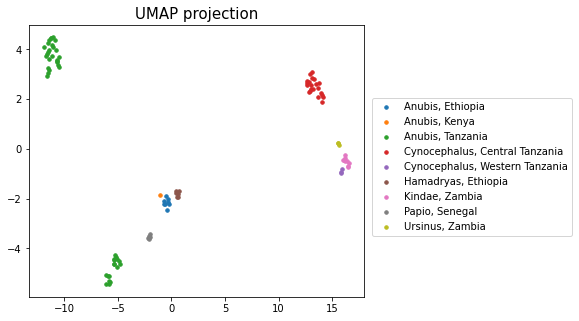

In [17]:
plot_umap(chrX_females_umap, 'X', 'Females')

### Diagnostic and connectivity plots

#### Females chromosome 7

In [18]:
scaled_df = StandardScaler().fit_transform(pruned_df)
mapper = umap.UMAP(random_state=23).fit(scaled_df.T)

<AxesSubplot:title={'center':'Colored by approx local dimension'}>

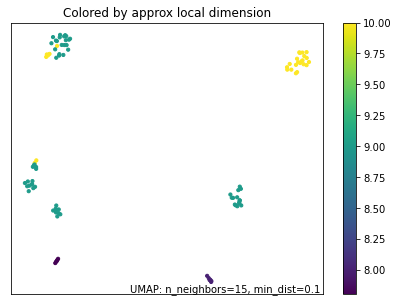

In [19]:
fig, ax = umap.plot.plt.subplots(figsize=(7,5))
umap.plot.diagnostic(mapper, diagnostic_type='local_dim', ax=ax)

<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

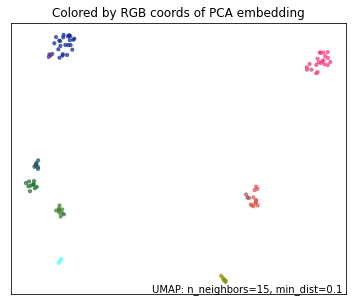

In [20]:
fig, ax = umap.plot.plt.subplots(figsize=(6,5))
umap.plot.diagnostic(mapper, diagnostic_type='pca', ax=ax)

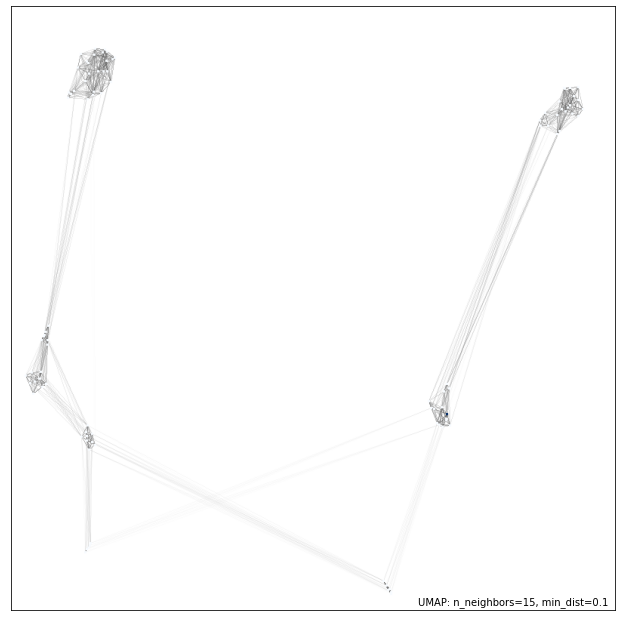

In [21]:
umap.plot.connectivity(mapper, show_points=True)
plt.savefig('../figures/females7_connectivity.pdf')

/home/janneae/miniconda3/envs/pib/lib/python3.7/site-packages/umap/plot.py:855: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


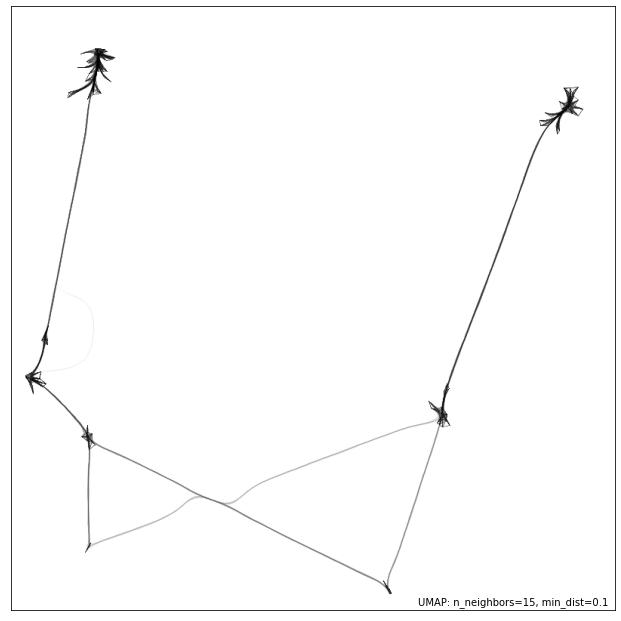

In [22]:
umap.plot.connectivity(mapper, edge_bundling='hammer')
plt.savefig('../figures/females7_hammer.pdf')

#### Females Chromosome X

In [23]:
scaled_dfX = StandardScaler().fit_transform(pruned_dfX)
mapperX = umap.UMAP(random_state=23).fit(scaled_dfX.T)

<AxesSubplot:title={'center':'Colored by approx local dimension'}>

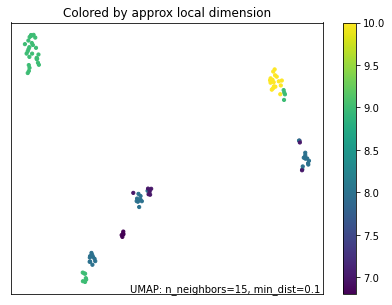

In [24]:
fig, ax = umap.plot.plt.subplots(figsize=(7,5))
umap.plot.diagnostic(mapperX, diagnostic_type='local_dim', ax=ax)

<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

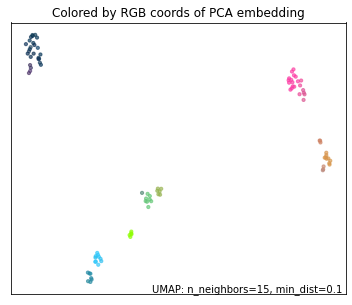

In [25]:
fig, ax = umap.plot.plt.subplots(figsize=(6,5))
umap.plot.diagnostic(mapperX, diagnostic_type='pca', ax=ax)

/home/janneae/miniconda3/envs/pib/lib/python3.7/site-packages/datashader/transfer_functions/__init__.py:282: RuntimeWarning: invalid value encountered in true_divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<AxesSubplot:>

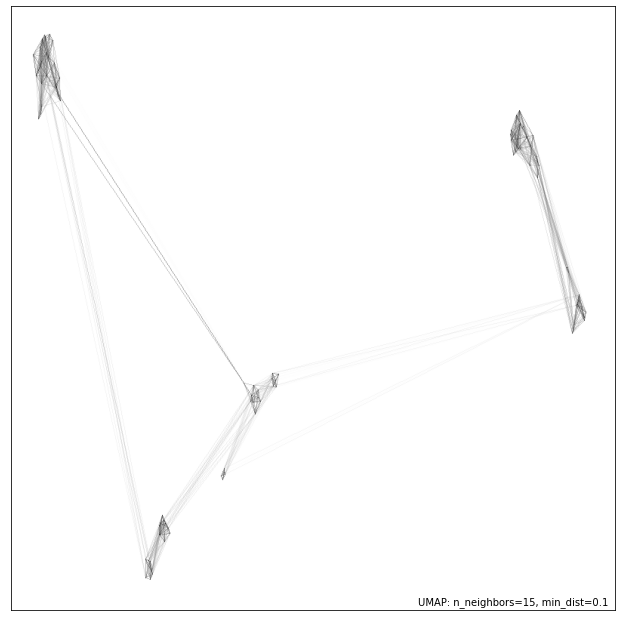

In [26]:
umap.plot.connectivity(mapperX, show_points=True)

/home/janneae/miniconda3/envs/pib/lib/python3.7/site-packages/umap/plot.py:855: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


<AxesSubplot:>

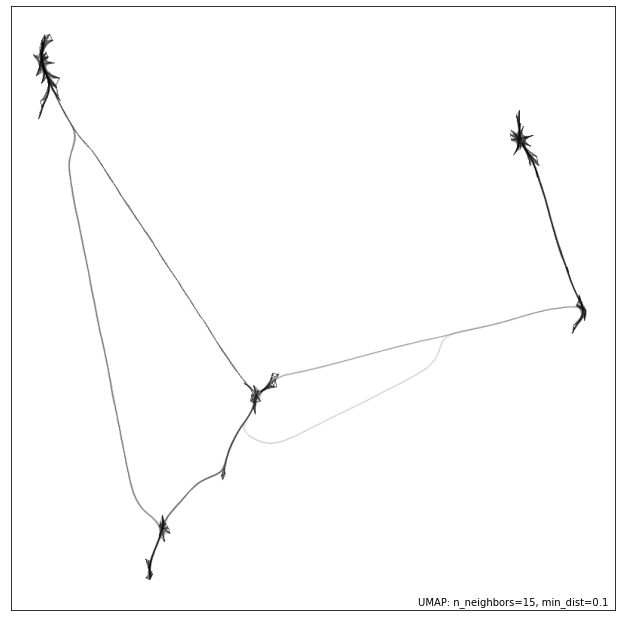

In [27]:
umap.plot.connectivity(mapperX, edge_bundling='hammer')